## Part 0 . Description
------------------------
To explore the driven affectors such as the number of days since the pop_up store opened, Seasonal factors **(such as day-of-the-week and hour-of-the-day)** , and location of study area and whether it is raining affect the hourly coffee sales, we will analyse the relative data and draw a conclusion based on the below inspection.

## Part 1. Load the Data
----------------------------

### 1.1 Import packages

In [114]:
import sqlite3
import math
import pandas as pd
import numpy as np
from scipy.stats import linregress
import scipy.stats as stats
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse 
import statsmodels.api as sm
from scipy.stats import kurtosis, skew

### 1.2 Load the Data

In [115]:
# Connect with database
conn = sqlite3.connect('cafe_insomnia.sqlite')

# Connect to the data in sqlite3 
Transaction = pd.read_sql('SELECT * FROM ci_transaction;',conn)
Drink = pd.read_sql('SELECT * FROM drink;',conn)
Study_area = pd.read_sql('SELECT * FROM study_area;', conn)


## Part 2. Find useful variables
-------------------

## Define the Variables

To successfully analyse the relationship between the seasonal factors (such as day-of-the-week and hour-of-the-day) and hourly sales, I perform a query to record useful details of each transaction. From the beginning, I define the hourly sales as the multiply quantity that customers ordered and the price of each item they purchased.

## Target - Hourly Sales
- *Quantity * Unit Price = Sales per Transaction*

Due to we have multiple transactions in one hour, hence after I calculate the sales for each transaction, I will make a further adjustment of hourly sales.

In [116]:
query = '''SELECT t.date,
                  t.day_of_week,
                  t.days_after_open,
                  t.hours_after_open,
                  t.quantity,
                  t.raining,
                  dist_to_cafe,
                  d.name, 
                  d.unit_price
           FROM ci_transaction t
           JOIN study_area s
            ON t.study_area_id = s.id
           JOIN drink d
           ON t.drink_id = d.id;'''

combine = pd.read_sql(query,conn)

In [117]:
cl = pd.read_sql('''SELECT c.id as cid, date, days_after_open, day_of_week, hours_after_open, drink_id, quantity, raining, study_area_id,s.name as study_name, dist_to_cafe, d.name as drink_name, unit_price
                            FROM ci_transaction c
                            JOIN study_area s
                            ON c.study_area_id = s.id
                            JOIN drink d
                            ON c.drink_id = d.id
                            ORDER BY c.hours_after_open ASC;''', conn)

In [118]:
combine['Sales (AUD)'] = combine['quantity'] * combine['unit_price']
# combine

In [119]:
combine['Daily_transaction'] = combine['date'] + '/' + combine['hours_after_open'].astype(str)
# print(combine['Daily_transaction'])

--------------------

In [120]:
cl

,cid,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,study_name,dist_to_cafe,drink_name,unit_price
0,0,2019-07-22,0,Mon,0,5,1,No,3,Abercrombie (H70),700,Flat White (L),4.9
1,1,2019-07-22,0,Mon,0,5,1,No,1,Law Library (F10),84,Flat White (L),4.9
2,2,2019-07-22,0,Mon,0,2,1,No,5,Carslaw (F07),150,Macchiato,3.8
3,3,2019-07-22,0,Mon,0,2,1,No,6,Peter Nicol Russell (PNR),950,Macchiato,3.8
4,4,2019-07-22,0,Mon,0,5,1,No,5,Carslaw (F07),150,Flat White (L),4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27166,27709,2019-12-22,153,Sun,5,14,2,No,3,Abercrombie (H70),700,Mocha (S),4.5
27167,27710,2019-12-22,153,Sun,5,6,1,No,3,Abercrombie (H70),700,Flat White (S),4.0
27168,27711,2019-12-22,153,Sun,5,12,1,No,0,Fisher Library (F03),70,Chai Latte (S),3.6
27169,27712,2019-12-22,153,Sun,5,9,1,No,4,Brennan MacCallum (A18),350,Cappuccino (L),4.9


In [121]:
print(cl.shape)

(27171, 13)


In [122]:
cl.describe()

,cid,days_after_open,hours_after_open,drink_id,quantity,study_area_id,dist_to_cafe,unit_price
count,27171.000000,27171.000000,27171.000000,27171.000000,27171.000000,27171.000000,27171.000000,27171.000000
mean,13853.333002,107.558868,2.376652,8.032829,1.267381,2.229841,243.756505,4.204873
std,7996.182672,36.822247,1.682285,4.873674,0.614285,2.104989,267.166341,0.566823
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,70.000000,3.300000
25%,6934.500000,89.000000,1.000000,4.000000,1.000000,0.000000,70.000000,3.800000
50%,13844.000000,117.000000,2.000000,8.000000,1.000000,1.000000,84.000000,4.000000
75%,20775.500000,136.000000,4.000000,12.000000,1.000000,4.000000,350.000000,4.600000
max,27713.000000,153.000000,5.000000,16.000000,4.000000,6.000000,950.000000,5.400000


In [123]:
cl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27171 entries, 0 to 27170
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cid               27171 non-null  int64  
 1   date              27171 non-null  object 
 2   days_after_open   27171 non-null  int64  
 3   day_of_week       27171 non-null  object 
 4   hours_after_open  27171 non-null  int64  
 5   drink_id          27171 non-null  int64  
 6   quantity          27171 non-null  int64  
 7   raining           27171 non-null  object 
 8   study_area_id     27171 non-null  int64  
 9   study_name        27171 non-null  object 
 10  dist_to_cafe      27171 non-null  int64  
 11  drink_name        27171 non-null  object 
 12  unit_price        27171 non-null  float64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.7+ MB


In [124]:
Transaction.info

<bound method DataFrame.info of           id        date  days_after_open day_of_week  hours_after_open  \
0          0  2019-07-22                0         Mon                 0   
1          1  2019-07-22                0         Mon                 0   
2          2  2019-07-22                0         Mon                 0   
3          3  2019-07-22                0         Mon                 0   
4          4  2019-07-22                0         Mon                 0   
...      ...         ...              ...         ...               ...   
27709  27709  2019-12-22              153         Sun                 5   
27710  27710  2019-12-22              153         Sun                 5   
27711  27711  2019-12-22              153         Sun                 5   
27712  27712  2019-12-22              153         Sun                 5   
27713  27713  2019-12-22              153         Sun                 5   

       drink_id  quantity raining  study_area_id  
0             5 

In [125]:
cl['study_name'].value_counts()

Fisher Library (F03)         7544
Law Library (F10)            6917
Carslaw (F07)                4728
Abercrombie (H70)            2024
Peter Nicol Russell (PNR)    2009
Brennan MacCallum (A18)      2003
The Quarter (A16)            1946
Name: study_name, dtype: int64

In [126]:
cl['drink_name'].value_counts()

Flat White (S)       1649
Cappuccino (L)       1641
Long Black (S)       1638
Chai Latte (S)       1634
Mocha (S)            1633
Macchiato            1630
Hot Chocolate (L)    1629
Mocha (L)            1609
Chai Latte (L)       1601
Flat White (L)       1598
Latte (S)            1596
Cappuccino (S)       1591
Long Black (L)       1570
Latte (L)            1562
Espresso             1560
Hot Chocolate (S)    1534
Ristretto            1496
Name: drink_name, dtype: int64

In [127]:
cl['dist_to_cafe'].value_counts()

70     7544
84     6917
150    4728
700    2024
950    2009
350    2003
400    1946
Name: dist_to_cafe, dtype: int64

In [128]:
cl['Daily_transaction'] = cl['date'] + '/' + cl['hours_after_open'].astype(str)
cl['Sales (AUD)'] = cl['quantity'] * cl['unit_price']
for col in cl.columns:
    print(col)
#https://www.geeksforgeeks.org/how-to-get-column-names-in-pandas-dataframe/

cl_Weekday_dummy = pd.get_dummies(cl.iloc[:,[3,7]], drop_first = True)
cl_without_sales = pd.concat([cl.iloc[:,[-2,4,-5]],cl_Weekday_dummy], axis = 1)
cl_without_sales = cl_without_sales.groupby('Daily_transaction').mean()
cl_hourly_sales = cl.groupby('Daily_transaction').sum()['Sales (AUD)']
cl_regression = pd.concat([cl_without_sales,cl_hourly_sales], axis = 1)
# display(cl_regression)

cid
date
days_after_open
day_of_week
hours_after_open
drink_id
quantity
raining
study_area_id
study_name
dist_to_cafe
drink_name
unit_price
Daily_transaction
Sales (AUD)


In [129]:
cl_regression.reset_index(inplace = True)
cl_regression.reset_index(inplace = True)

In [130]:
cl_regression.rename(columns={"index": "hours_open_till_enddate"},inplace = True)
cl_regression

,hours_open_till_enddate,Daily_transaction,hours_after_open,dist_to_cafe,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,raining_Yes,Sales (AUD)
0,0,2019-07-22/0,0.0,264.363636,1,0,0,0,0,0,0,49.0
1,1,2019-07-22/1,1.0,246.769231,1,0,0,0,0,0,0,83.6
2,2,2019-07-22/2,2.0,77.000000,1,0,0,0,0,0,1,37.3
3,3,2019-07-22/3,3.0,471.000000,1,0,0,0,0,0,0,50.6
4,4,2019-07-22/4,4.0,101.333333,1,0,0,0,0,0,1,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...
919,919,2019-12-22/1,1.0,274.741935,0,0,1,0,0,0,0,364.7
920,920,2019-12-22/2,2.0,285.180328,0,0,1,0,0,0,0,326.1
921,921,2019-12-22/3,3.0,81.440000,0,0,1,0,0,0,1,266.0
922,922,2019-12-22/4,4.0,317.206897,0,0,1,0,0,0,0,320.7


--------------------

# -Part 2 Days since open

In [131]:
#Select required data to make a completed form

complete_query = '''Select c.days_after_open, c.hours_after_open, c.quantity, d.name, d.unit_price
                    FROM ci_transaction c
                    Left join drink d
                    ON c.drink_id = d.id; '''

complete_table = pd.read_sql(complete_query, conn)

#Define a form: Hourly sales = quantity * Unit_Price, then create a new column named as 'Sales (AUD)'

complete_table['Sales'] = complete_table['quantity'] * complete_table['unit_price']
# complete_table

### Further check 

In [132]:
combine['hours_after_open'].value_counts()

1    4985
2    4804
0    4750
3    4480
4    4217
5    3935
Name: hours_after_open, dtype: int64

In [133]:
combine['hours_after_open'].to_numpy()

array([0, 0, 0, ..., 5, 5, 5])

# Numerial and Graphic Analysis


### 2.1 The relationship between average hourly sales and days after open

In [134]:
Average_hourly_sales_per_day = combine.groupby(['days_after_open','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
print(Average_hourly_sales_per_day)
print(Average_hourly_sales_per_day.shape)

     days_after_open Daily_transaction  Sales (AUD)
0                  0      2019-07-22/0         49.0
1                  0      2019-07-22/1         83.6
2                  0      2019-07-22/2         37.3
3                  0      2019-07-22/3         50.6
4                  0      2019-07-22/4         16.1
..               ...               ...          ...
919              153      2019-12-22/1        364.7
920              153      2019-12-22/2        326.1
921              153      2019-12-22/3        266.0
922              153      2019-12-22/4        320.7
923              153      2019-12-22/5        278.5

[924 rows x 3 columns]
(924, 3)


In [135]:
Average_hourly_sales_per_day.describe()

,days_after_open,Sales (AUD)
count,924.000000,924.000000
mean,76.500000,156.645455
std,44.479109,120.083250
min,0.000000,4.000000
25%,38.000000,54.175000
50%,76.500000,104.100000
75%,115.000000,269.675000
max,153.000000,432.100000


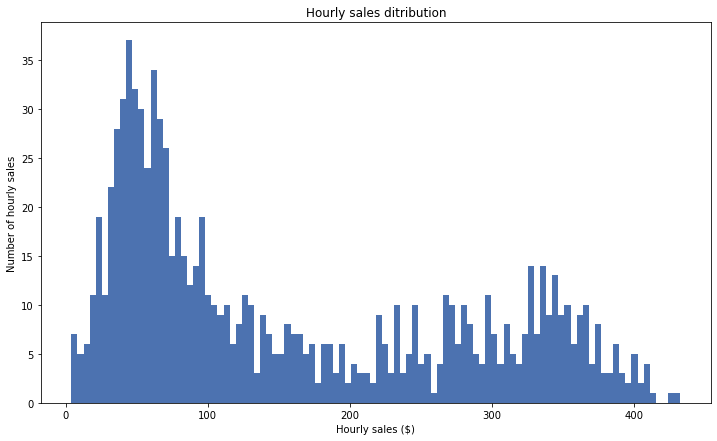

In [136]:
plt.figure(figsize=(12,7))
plt.hist(Average_hourly_sales_per_day['Sales (AUD)'], bins = 100)

plt.title("Hourly sales ditribution")
plt.xlabel("Hourly sales ($)")
plt.ylabel('Number of hourly sales')

plt.show()

In [137]:
print( 'excess kurtosis of normal distribution (should be 0): {:.4f}'.format(kurtosis(Average_hourly_sales_per_day['Sales (AUD)'])))
print( 'skewness of normal distribution (should be 0): {:.4f}'.format(skew(Average_hourly_sales_per_day['Sales (AUD)'])))
print(Average_hourly_sales_per_day['Sales (AUD)'].describe())

excess kurtosis of normal distribution (should be 0): -1.1005
skewness of normal distribution (should be 0): 0.6168
count    924.000000
mean     156.645455
std      120.083250
min        4.000000
25%       54.175000
50%      104.100000
75%      269.675000
max      432.100000
Name: Sales (AUD), dtype: float64


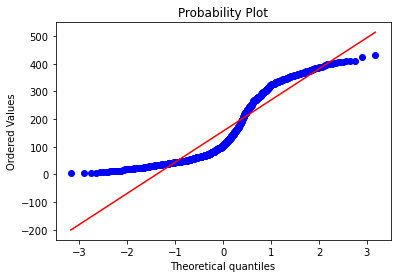

In [138]:
qq_plot = stats.probplot(Average_hourly_sales_per_day['Sales (AUD)'], plot=plt)

### 2.1.2 Graphic  Analysis

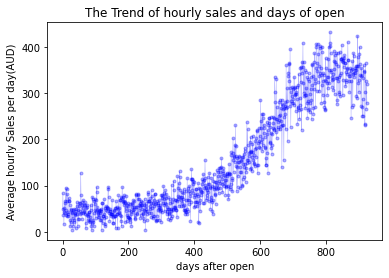

In [139]:
plt.plot(Average_hourly_sales_per_day['Sales (AUD)'], '.-', color = 'blue', alpha = 0.3, linewidth = 0.5)

plt.xlabel('days after open')
plt.ylabel('Average hourly Sales per day(AUD)')
plt.title('The Trend of hourly sales and days of open')

plt.show()

## 2.2 The relationship of hourly sales and Cup Sizes

In [140]:
#create a size function

def size_function(d):
    if '(L)'in d:
       size = 'Large'
    elif '(S)' in d:
        size = 'Small'
    else:
        size = 'Standard'
    return size 

In [141]:
complete_table['Size'] = complete_table['name'].apply(size_function)
# complete_table

### 2.2.1 Numerial Analysis

In [142]:
complete_table.groupby('Size')['quantity'].sum()

Size
Large       14432
Small       14603
Standard     6076
Name: quantity, dtype: int64

### 2.2.2 Graphic Analysis

In [143]:
Small_table = complete_table.query("Size == 'Small'")
# Small_table

In [144]:
#Small cups Average_hourly_sales_per_day
Small_cups = Small_table.groupby('days_after_open')['Sales'].sum()/6
# Small_cups

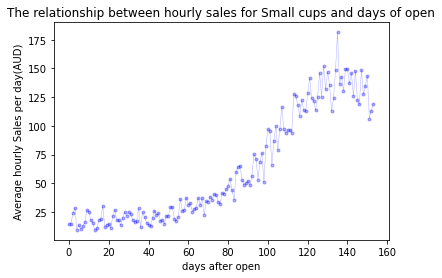

In [145]:
#The relationship between hourly sales for Small_cups and days_after_open

plt.plot(Small_cups, '.-', color = 'blue', alpha = 0.3, linewidth = 0.5)

plt.xlabel('days after open')
plt.ylabel('Average hourly Sales per day(AUD)')
plt.title('The relationship between hourly sales for Small cups and days of open')

plt.show()


### 2.2.3 Comparision

In [146]:
Large_table = complete_table.query("Size == 'Large'")
# Large_table

In [147]:
Large_cups = Large_table.groupby('days_after_open')['Sales'].sum()/6
# Large_cups

In [148]:
Standard_table = complete_table.query("Size == 'Standard'")
# Standard_table

In [149]:
Standard_cups = Standard_table.groupby('days_after_open')['Sales'].sum()/6
# Standard_cups

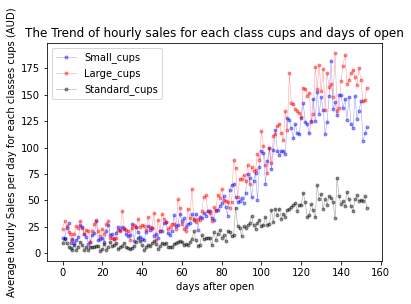

In [150]:
#make plots
plt.plot(Small_cups, '.-', color = 'blue', alpha = 0.4, linewidth = 0.5, label = 'Small_cups')
plt.plot(Large_cups,  '.-', color = 'red', alpha = 0.4, linewidth = 0.5, label = 'Large_cups')
plt.plot(Standard_cups,  '.-', color = 'black', alpha = 0.4, linewidth = 0.5, label = 'Standard_cups')

#create lables
plt.xlabel('days after open')
plt.ylabel('Average hourly Sales per day for each classes cups (AUD)')

plt.title('The Trend of hourly sales for each class cups and days of open')
plt.legend()
plt.show()

--------------------

# -Part 3 Seasonal factors

### 3.1 **Day of the Week**

In [151]:
combine_a = combine.groupby(['day_of_week', 'Daily_transaction'])['Sales (AUD)'].sum().reset_index()
combine_a = combine_a.groupby(['day_of_week']).mean()
combine_a = combine_a.reindex(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
# combine_a

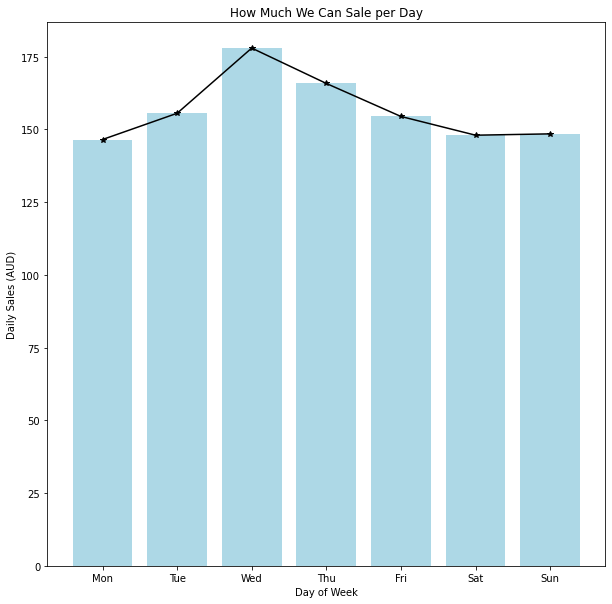

In [152]:
plt.figure(figsize=(10,10))
plt.bar(combine_a.index, combine_a['Sales (AUD)'], color = 'lightblue')
plt.plot(combine_a.index, combine_a, c = 'black', marker = '*')

plt.xlabel('Day of Week')
plt.ylabel('Daily Sales (AUD)')
plt.title('How Much We Can Sale per Day')

plt.show()

In [153]:
def size (name):
    if '(L)' in name:
        return 'Large'
    elif '(S)' in name:
        return 'Small'
    else:
        return 'Other'

In [154]:
combine['drink_size'] = combine['name'].apply(size)

In [155]:
L = combine.loc[combine['drink_size'].str.contains('L')]
S = combine.loc[combine['drink_size'].str.contains('S')]
O = combine.loc[combine['drink_size'].str.contains('O')]

In [156]:
dow_hour_L = L.groupby(['day_of_week','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
dow_hour_L_gb = dow_hour_L.groupby(['day_of_week']).mean().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

In [157]:
dow_hour_S = S.groupby(['day_of_week','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
dow_hour_S_gb = dow_hour_S.groupby(['day_of_week']).mean().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

In [158]:
dow_hour_O = O.groupby(['day_of_week','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
dow_hour_O_gb = dow_hour_O.groupby(['day_of_week']).mean().reindex(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

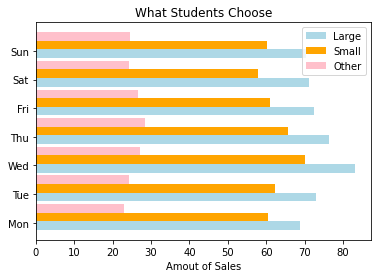

In [159]:
ypos = [0, 1, 2, 3, 4, 5, 6]
Large = np.array(dow_hour_L_gb['Sales (AUD)'])
Small = np.array(dow_hour_S_gb['Sales (AUD)'])
Other = np.array(dow_hour_O_gb['Sales (AUD)'])

h = 0.3 # height
adjusted_ypos = np.add(ypos, h)
yticks = np.add(ypos,h/3)
plt.barh(ypos, Large, height = h, color = 'lightblue', label = 'Large')
plt.barh(adjusted_ypos, Small, height = h, color = 'orange', label = 'Small')
plt.barh(adjusted_ypos+h, Other, height = h, color = 'pink', label = 'Other')

item = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
plt.yticks(ypos, item)

plt.xlabel('Amout of Sales')
plt.yticks(yticks, item)
plt.title('What Students Choose')
plt.legend()

plt.show()

### 3.2 **Hour of the Day**

In [160]:
hod_hour = combine.groupby(['hours_after_open', 'Daily_transaction'])['Sales (AUD)'].sum().reset_index()

In [161]:
hod_hour_gb = hod_hour.groupby(['hours_after_open']).mean()

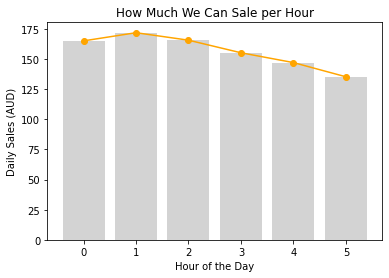

In [162]:
plt.bar(hod_hour_gb.index, hod_hour_gb['Sales (AUD)'], color = 'lightgray')
plt.plot(hod_hour_gb.index, hod_hour_gb, c = 'orange', marker = 'o')

plt.xlabel('Hour of the Day')
plt.ylabel('Daily Sales (AUD)')
plt.title('How Much We Can Sale per Hour')

plt.show()

In [163]:
hod_hour_L = L.groupby(['hours_after_open','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
hod_hour_L_gb = hod_hour_L.groupby(['hours_after_open']).mean()


In [164]:
hod_hour_S = S.groupby(['hours_after_open','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
hod_hour_S_gb = hod_hour_S.groupby(['hours_after_open']).mean()


In [165]:
hod_hour_O = O.groupby(['hours_after_open','Daily_transaction'])['Sales (AUD)'].sum().reset_index()
hod_hour_O_gb = hod_hour_O.groupby(['hours_after_open']).mean()


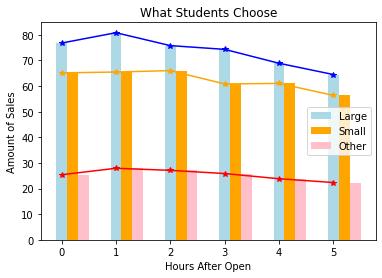

In [166]:
xpos = [0, 1, 2, 3, 4, 5]
Large = np.array(hod_hour_L_gb['Sales (AUD)'])
Small = np.array(hod_hour_S_gb['Sales (AUD)'])
Other = np.array(hod_hour_O_gb['Sales (AUD)'])

w = 0.2 # width
adjusted_xpos = np.add(xpos, w)
xticks = np.add(xpos,w)
plt.bar(xpos, Large, width = w, color = 'lightblue', label = 'Large')
plt.plot(Large, c = 'blue', marker = "*")
plt.bar(adjusted_xpos, Small, width = w, color = 'orange', label = 'Small')
plt.plot(Small, c = 'orange', marker = "*")
plt.bar(adjusted_xpos+w, Other, width = w, color = 'pink', label = 'Other')
plt.plot(Other, c = 'red', marker = "*")

plt.xlabel('Hours After Open')
plt.ylabel('Amount of Sales')
plt.title('What Students Choose')
plt.legend()

plt.show()

--------------------

# -Part 4 Raining & Study Area factors

## 4.1 Bar chart of sales by raining variable:

In [167]:
days = combine[['raining','hours_after_open','days_after_open','Sales (AUD)']]
hourly_day = days.groupby(["raining","hours_after_open"]).sum()

Value count on days of raining: 
No     19768
Yes     7403
Name: raining, dtype: int64


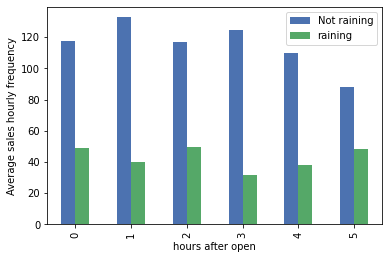

<class 'list'>


In [168]:
raining_count = cl['raining'].value_counts()
print('Value count on days of raining: ')
print(raining_count)

norain_hourly_day_mean = []

for sale in hourly_day['Sales (AUD)'][:6]:
    norain_hourly_day_mean.append(sale/153)
# print(norain_hourly_day_mean)

yesrain_hourly_day_mean = []

for sale in hourly_day ['Sales (AUD)'][6:]:
    yesrain_hourly_day_mean.append(sale/153)
# print(yesrain_hourly_day_mean)

plt.style.use('seaborn-deep')
x = [0 ,1 ,2 ,3 ,4, 5]
result = pd.DataFrame(np.c_[norain_hourly_day_mean,yesrain_hourly_day_mean], index = x)
result.plot.bar()
plt.xlabel('hours after open')
plt.ylabel('Average sales hourly frequency')
plt.legend(['Not raining','raining'], loc = 'upper right')

plt.show()
print(type(norain_hourly_day_mean))

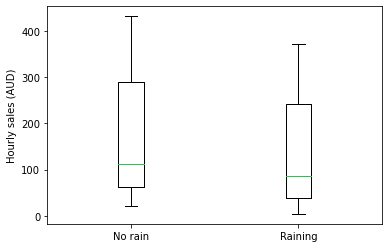

In [169]:
X = cl_regression['Sales (AUD)'].loc[cl_regression['raining_Yes'] == 0 ].to_numpy()
y = cl_regression['Sales (AUD)'].loc[cl_regression['raining_Yes'] == 1 ].to_numpy()

plt.boxplot((X,y),labels=["No rain", "Raining"])
plt.ylabel('Hourly sales (AUD)')
plt.show()

In [170]:
area_for_each_id_cl = cl[['cid','study_area_id', 'study_name']]

In [171]:
count_for_each_study_area = area_for_each_id_cl.groupby(['study_name']).count()

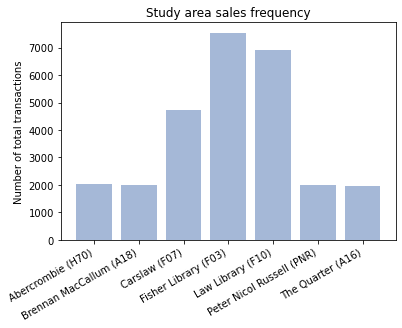

                            cid  study_area_id
study_name                                    
Abercrombie (H70)          2024           2024
Brennan MacCallum (A18)    2003           2003
Carslaw (F07)              4728           4728
Fisher Library (F03)       7544           7544
Law Library (F10)          6917           6917
Peter Nicol Russell (PNR)  2009           2009
The Quarter (A16)          1946           1946


In [172]:
objects = count_for_each_study_area.index.tolist()
y_pos = np.arange(len(objects))
performance = list(count_for_each_study_area['cid'])

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects,ha='right', rotation = 30)
plt.ylabel('Number of total transactions')
plt.title('Study area sales frequency')

plt.show()
print(count_for_each_study_area)

In [173]:
total_sales_location = cl.groupby(['study_name'])['Sales (AUD)'].sum().reset_index()
total_sales_location

,study_name,Sales (AUD)
0,Abercrombie (H70),10975.9
1,Brennan MacCallum (A18),10550.7
2,Carslaw (F07),25192.0
3,Fisher Library (F03),40300.4
4,Law Library (F10),36527.9
5,Peter Nicol Russell (PNR),10945.9
6,The Quarter (A16),10247.6


In [174]:
hourly_sales_location = cl.groupby(['study_name'])['Sales (AUD)'].sum()/923
hourly_sales_location = pd.DataFrame(data=hourly_sales_location)
print(type(hourly_sales_location))
hourly_sales_location

<class 'pandas.core.frame.DataFrame'>


,Sales (AUD)
study_name,
Abercrombie (H70),11.891549
Brennan MacCallum (A18),11.430878
Carslaw (F07),27.293608
Fisher Library (F03),43.662405
Law Library (F10),39.575190
Peter Nicol Russell (PNR),11.859047
The Quarter (A16),11.102492


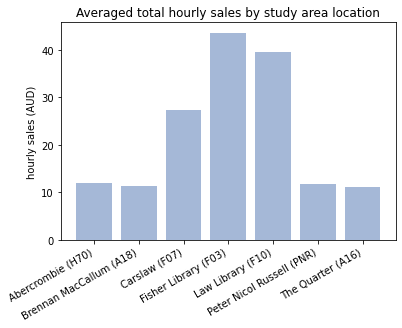

In [175]:
objects = hourly_sales_location.index.tolist()
y_pos = np.arange(len(objects))
performance = list(hourly_sales_location['Sales (AUD)'])

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects,ha='right', rotation = 30)
plt.ylabel('hourly sales (AUD)')
plt.title('Averaged total hourly sales by study area location')

plt.show()

## 4.2 Location Correlation

In [176]:
area_for_each_id_cll = cl[['cid', 'study_area_id']]
# area_for_each_id_cll

In [177]:
count_for_each_study_areaa = area_for_each_id_cll.groupby(['study_area_id']).count()
# print(count_for_each_study_areaa)

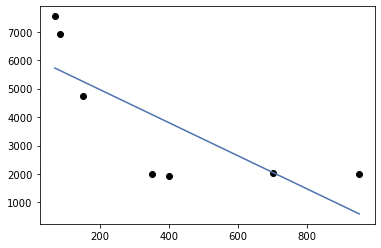

slope of the graph: 
LinregressResult(slope=-5.824081076342936, intercept=6131.330747204471, rvalue=-0.7747506449080112, pvalue=0.04079330459040322, stderr=2.12559692419596)
Correlation: -0.7748


In [178]:
count_for_each_study_area
study_area = pd.read_sql('''SELECT s.id, s.dist_to_cafe FROM study_area s ORDER BY s.id ASC;''', conn)

x = list(study_area['dist_to_cafe'])
y = list(count_for_each_study_areaa['cid'])

plt.scatter(x, y, marker = 'o', color = 'black')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
# reference from：https://stackoverflow.com/questions/22239691/code-for-best-fit-straight-line-of-a-scatter-plot-in-python

plt.show()
print('slope of the graph: ')
print(linregress(x, y))

print('Correlation: {:.4f}'.format(study_area['dist_to_cafe'].corr(count_for_each_study_areaa['cid'])))

## 4.3 Extention on Location Correlation -  Linear Regression

In [179]:
X = study_area["dist_to_cafe"].to_numpy()
y = count_for_each_study_areaa['cid']

linear_reg = LinearRegression()
linear_reg.fit(X.reshape(-1,1), y)

print('beta 0: {:.2f}'.format(linear_reg.intercept_))
print('beta 1: {:.2f}'.format(linear_reg.coef_[0]))

beta 0: 6131.33
beta 1: -5.82


In [180]:
X = cl_regression["dist_to_cafe"].to_numpy()
y = cl_regression['Sales (AUD)'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.4, random_state = 1)

linear_reg = LinearRegression()
linear_reg.fit(X_train.reshape(-1,1), y_train)
pred_y = linear_reg.predict(X_test.reshape(-1,1))


print('beta 0: {:.2f}'.format(linear_reg.intercept_))
print('beta 1: {:.2f}'.format(linear_reg.coef_[0]))
X_1 = sm.add_constant(X)
model = sm.OLS(y, X_1).fit()
predictions = model.predict(X_1) 
# https://datatofish.com/multiple-linear-regression-python/
print_model = model.summary()
print(print_model)
print(mse(pred_y,y_test))
print(r2_score(y_test,pred_y))
print('RMSE: {:.4f}'.format(np.sqrt(mse(pred_y,y_test))))


beta 0: 123.10
beta 1: 0.13
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     13.92
Date:                Sun, 06 Jun 2021   Prob (F-statistic):           0.000202
Time:                        17:31:00   Log-Likelihood:                -5728.0
No. Observations:                 924   AIC:                         1.146e+04
Df Residuals:                     922   BIC:                         1.147e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.0770   

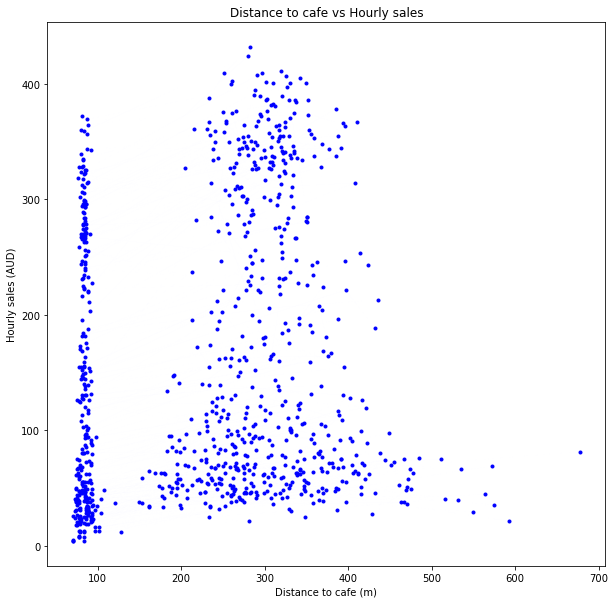

In [181]:
opd = cl_regression[['dist_to_cafe','Sales (AUD)']].reset_index(drop=True).to_numpy()
plt.figure(figsize=(10,10))

plt.plot(opd[:,0], opd[:,1], '.-', color = 'blue', alpha = 1, linewidth = 0.0005)
plt.ylabel('Hourly sales (AUD)')
plt.xlabel('Distance to cafe (m)')
plt.title('Distance to cafe vs Hourly sales')


plt.show()

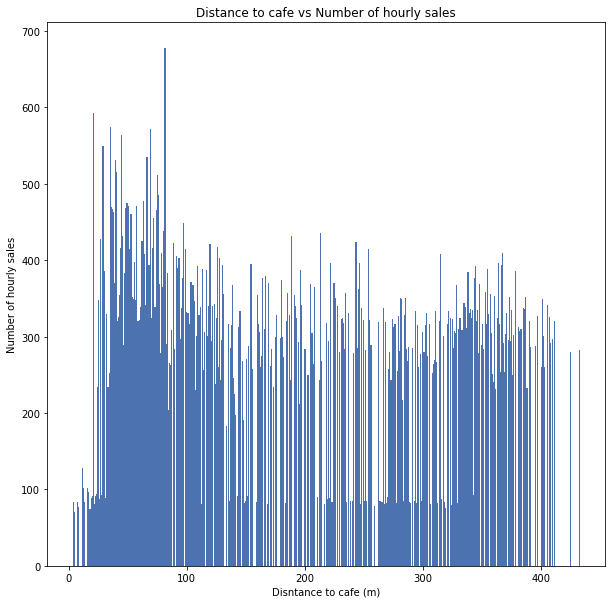

In [182]:
plt.figure(figsize=(10,10))

X = opd[:,0]
y = opd[:,1]
plt.bar(y, X, width = 1)

plt.xlabel('Disntance to cafe (m)')
plt.ylabel('Number of hourly sales')
plt.title('Distance to cafe vs Number of hourly sales')

plt.show()

In [183]:
study_area_hours_after_open = pd.crosstab(cl['hours_after_open'], cl['study_name'])
study_area_hours_after_open

study_name,Abercrombie (H70),Brennan MacCallum (A18),Carslaw (F07),Fisher Library (F03),Law Library (F10),Peter Nicol Russell (PNR),The Quarter (A16)
hours_after_open,,,,,,,
0,320,344,844,1340,1217,339,346
1,399,394,913,1348,1198,374,359
2,365,326,753,1395,1302,334,329
3,368,366,853,1117,1091,370,315
4,314,314,745,1149,1062,312,321
5,258,259,620,1195,1047,280,276


In [184]:
study_area_hours_after_open_proportion = study_area_hours_after_open.div(study_area_hours_after_open.sum(axis=1), axis= 0)
# https://stackoverflow.com/questions/50820659/compute-row-percentages-in-pandas-dataframe
study_area_hours_after_open_proportion

study_name,Abercrombie (H70),Brennan MacCallum (A18),Carslaw (F07),Fisher Library (F03),Law Library (F10),Peter Nicol Russell (PNR),The Quarter (A16)
hours_after_open,,,,,,,
0,0.067368,0.072421,0.177684,0.282105,0.256211,0.071368,0.072842
1,0.080040,0.079037,0.183149,0.270411,0.240321,0.075025,0.072016
2,0.075978,0.067860,0.156744,0.290383,0.271024,0.069525,0.068485
3,0.082143,0.081696,0.190402,0.249330,0.243527,0.082589,0.070312
4,0.074461,0.074461,0.176666,0.272469,0.251838,0.073986,0.076120
5,0.065565,0.065820,0.157560,0.303685,0.266074,0.071156,0.070140


## CLUSTER

,hours_open_till_enddate,Daily_transaction,hours_after_open,dist_to_cafe,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,raining_Yes,Sales (AUD)
0,0,2019-07-22/0,0.0,264.363636,1,0,0,0,0,0,0,49.0
1,1,2019-07-22/1,1.0,246.769231,1,0,0,0,0,0,0,83.6
2,2,2019-07-22/2,2.0,77.000000,1,0,0,0,0,0,1,37.3
3,3,2019-07-22/3,3.0,471.000000,1,0,0,0,0,0,0,50.6
4,4,2019-07-22/4,4.0,101.333333,1,0,0,0,0,0,1,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...
919,919,2019-12-22/1,1.0,274.741935,0,0,1,0,0,0,0,364.7
920,920,2019-12-22/2,2.0,285.180328,0,0,1,0,0,0,0,326.1
921,921,2019-12-22/3,3.0,81.440000,0,0,1,0,0,0,1,266.0
922,922,2019-12-22/4,4.0,317.206897,0,0,1,0,0,0,0,320.7


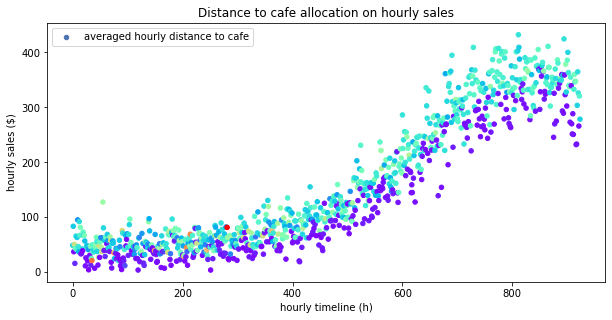

In [185]:
display(cl_regression)
plt.figure(figsize=(10,10))

cl_regression_na = cl_regression.iloc[:,[0,3,-1]].to_numpy()
cl_regression_na[:,1] = (cl_regression_na[:,1]-cl_regression_na[:,1].min())/(cl_regression_na[:,1].max()-cl_regression_na[:,1].min())
plt.scatter(cl_regression_na[:,0], cl_regression_na[:,2], s = 20, label = 'Data', cmap = 'rainbow', c = cl_regression_na[:,1])
plt.title('Distance to cafe allocation on hourly sales');plt.xlabel('hourly timeline (h)'); plt.ylabel('hourly sales ($)'); plt.legend(labels = ['averaged hourly distance to cafe']); plt.axis('scaled'); plt.show();


--------------------

## CORRELATION:

In [186]:
'''
RAINIG VS SALES CORREL
'''
# combine['Daily_transaction'] = combine['date'] + '/' + combine['hours_after_open'].astype(str)
raining_hourly = combine.groupby(['Daily_transaction','raining'])['Sales (AUD)'].sum().reset_index()
rain_dummy = pd.get_dummies(raining_hourly['raining'],drop_first = True)
raining_hourly = pd.concat([raining_hourly, rain_dummy], axis =1)
combine.insert(9,'Raining',raining_hourly['Yes'],allow_duplicates=False)
# print(raining_hourly)
from scipy.stats import pearsonr
r = pearsonr(raining_hourly['Sales (AUD)'].to_numpy(),raining_hourly['Yes'].to_numpy())
print('RAINIG Correlation: {:.4f}, p-value: {:.8f}'.format(r[0],r[1]))
# raining_hourly.to_excel("raining_houly.xlsx") 


'''
DIST_TO_CAFE VS SALES CORREL
'''
studyid_hourly = combine.groupby(['Daily_transaction','dist_to_cafe'])['Sales (AUD)'].sum().reset_index()
# print(studyid_hourly)
r1 = pearsonr(studyid_hourly['Sales (AUD)'].to_numpy(),studyid_hourly['dist_to_cafe'].to_numpy())
print('DIST_TO_CAFE Correlation: {:.4f}, p-value: {:.8f}'.format(r1[0],r1[1]))


'''
DAYS_OPEN VS SALES CORREL
'''
days_open_hourly = combine.groupby(['days_after_open'])['Sales (AUD)'].sum().reset_index()
# print(days_open_hourly)
r2 = pearsonr(days_open_hourly['Sales (AUD)'].to_numpy(),days_open_hourly['days_after_open'].to_numpy())
print('DAYS_OPEN Correlation: {:.4f}, p-value: {:.8f}'.format(r2[0],r2[1]))

'''
HOURS_OPEN VS SALES CORREL
'''
hours_open_hourly = combine.groupby(['hours_after_open'])['Sales (AUD)'].sum().reset_index()
# print(days_open_hourly)
r4 = pearsonr(hours_open_hourly['Sales (AUD)'].to_numpy(),hours_open_hourly['hours_after_open'].to_numpy())
print('HOURS_OPEN Correlation: {:.4f}, p-value: {:.8f}'.format(r4[0],r4[1]))


'''
DAY_OF_WEEK VS SALES CORREL
'''
combine.day_of_week = pd.Categorical(combine.day_of_week)
combine['day_of_week'] = combine.day_of_week.cat.codes
day_of_week_hourly = combine.groupby(['day_of_week'])['Sales (AUD)'].sum().reset_index()
# https://stackoverflow.com/questions/38088652/pandas-convert-categories-to-numbers/38089089
# print(day_of_week_hourly)
r3 = pearsonr(day_of_week_hourly['Sales (AUD)'].to_numpy(),day_of_week_hourly['day_of_week'].to_numpy())
print('day_of_week Correlation: {:.4f}, p-value: {:.8f}'.format(r3[0],r3[1]))





RAINIG Correlation: -0.1443, p-value: 0.00001069
DIST_TO_CAFE Correlation: -0.2681, p-value: 0.00000000
DAYS_OPEN Correlation: 0.9315, p-value: 0.00000000
HOURS_OPEN Correlation: -0.9145, p-value: 0.01064799
day_of_week Correlation: 0.7160, p-value: 0.07033141


In [187]:
cl_regression

,hours_open_till_enddate,Daily_transaction,hours_after_open,dist_to_cafe,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,raining_Yes,Sales (AUD)
0,0,2019-07-22/0,0.0,264.363636,1,0,0,0,0,0,0,49.0
1,1,2019-07-22/1,1.0,246.769231,1,0,0,0,0,0,0,83.6
2,2,2019-07-22/2,2.0,77.000000,1,0,0,0,0,0,1,37.3
3,3,2019-07-22/3,3.0,471.000000,1,0,0,0,0,0,0,50.6
4,4,2019-07-22/4,4.0,101.333333,1,0,0,0,0,0,1,16.1
...,...,...,...,...,...,...,...,...,...,...,...,...
919,919,2019-12-22/1,1.0,274.741935,0,0,1,0,0,0,0,364.7
920,920,2019-12-22/2,2.0,285.180328,0,0,1,0,0,0,0,326.1
921,921,2019-12-22/3,3.0,81.440000,0,0,1,0,0,0,1,266.0
922,922,2019-12-22/4,4.0,317.206897,0,0,1,0,0,0,0,320.7


In [188]:
r5 = pearsonr(cl['Sales (AUD)'].to_numpy(),cl['quantity'].to_numpy())
print('Quantity vs single transaction Correlation: {:.4f}, p-value: {:.8f}'.format(r5[0],r5[1]))

Quantity vs single transaction Correlation: 0.9558, p-value: 0.00000000


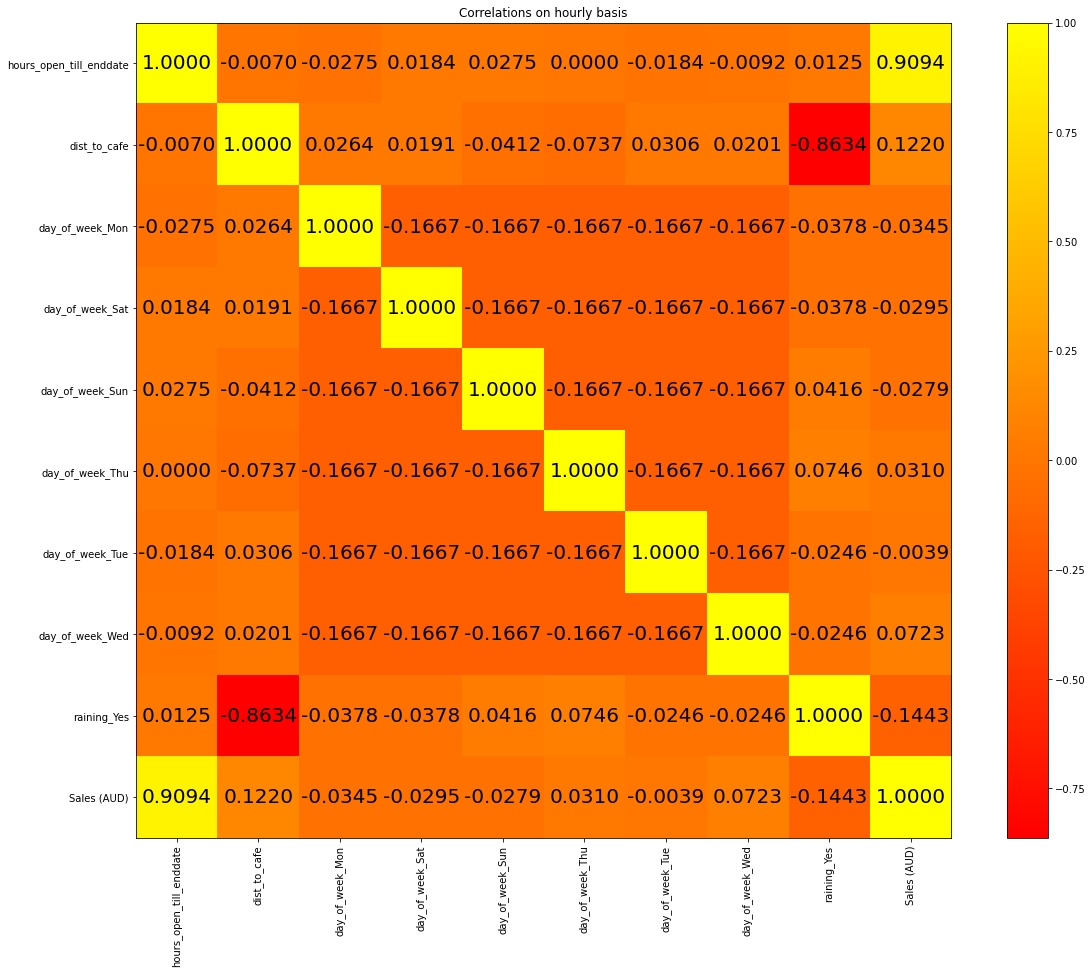

In [189]:
# Calculate correlation matrix
plt.figure(figsize=(20,15))
corr = cl_regression.iloc[:,[0,3,4,5,6,7,8,9,10,11]].corr()
n_var = len(corr)


plt.imshow(corr, cmap = 'autumn')

plt.xticks(range(n_var), corr.columns)
plt.yticks(range(n_var), corr.columns)

for i in range(n_var):
    for j in range(n_var):
        plt.text(i,j,'{:.4f}'.format(corr.iloc[i,j]), ha = 'center', va = 'center', color = 'k', fontsize = 20)

plt.colorbar()
plt.xticks(rotation = 90)
plt.title('Correlations on hourly basis')
plt.show()

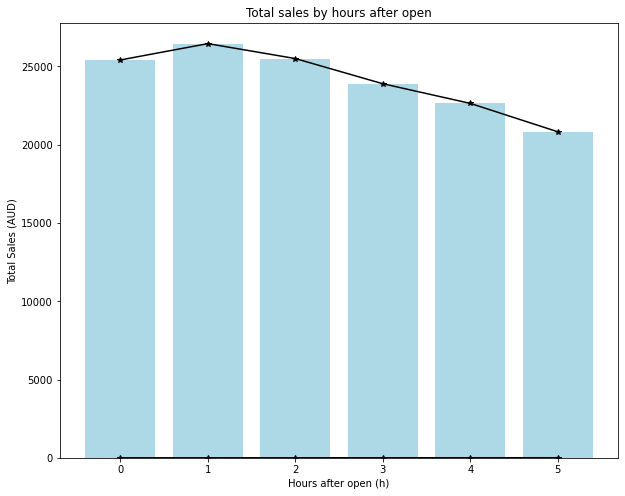

In [190]:
'''
Total sales by hours after open
'''
hours_open_hourly
plt.figure(figsize=(10,8))
plt.bar(hours_open_hourly.index, hours_open_hourly['Sales (AUD)'], color = 'lightblue')
plt.plot(hours_open_hourly.index, hours_open_hourly, c = 'black', marker = '*')

plt.xlabel('Hours after open (h)')
plt.ylabel('Total Sales (AUD)')
plt.title('Total sales by hours after open')

plt.show()

In [191]:
print('Average distance to cafe: {:.4f}m'.format(cl_regression["dist_to_cafe"].mean()))
print('Average hourly sales: ${:.4f}'.format(cl_regression["Sales (AUD)"].mean()))


Average distance to cafe: 232.9023m
Average hourly sales: $156.6455


In [192]:
drink_sale_quantity = cl.groupby(['drink_name', 'unit_price']).sum()['quantity'].sort_values()
drink_sale_quantity

drink_name         unit_price
Ristretto          3.3           1889
Latte (L)          4.9           1947
Hot Chocolate (S)  3.8           1948
Long Black (L)     4.0           1997
Mocha (L)          5.4           2001
Espresso           3.5           2003
Latte (S)          4.0           2012
Cappuccino (S)     4.0           2013
Chai Latte (L)     4.4           2038
Flat White (L)     4.9           2041
Macchiato          3.8           2052
Chai Latte (S)     3.6           2064
Cappuccino (L)     4.9           2065
Flat White (S)     4.0           2087
Mocha (S)          4.5           2091
Hot Chocolate (L)  4.6           2092
Long Black (S)     3.8           2096
Name: quantity, dtype: int64

## Highest sale in location

In [193]:
location_quantity_sale = cl.groupby(['drink_name','study_name']).sum()['quantity'].unstack()
# location_quantity_sale_list = cl.groupby(['drink_name','study_name']).sum()['quantity'].reset_index()
describe_location_quantity = location_quantity_sale.describe(exclude=[object])
display(location_quantity_sale)
describe_location_quantity

study_name,Abercrombie (H70),Brennan MacCallum (A18),Carslaw (F07),Fisher Library (F03),Law Library (F10),Peter Nicol Russell (PNR),The Quarter (A16)
drink_name,,,,,,,
Cappuccino (L),149,183,305,602,482,162,182
Cappuccino (S),167,145,343,520,531,150,157
Chai Latte (L),153,147,327,573,538,141,159
Chai Latte (S),158,152,389,544,516,168,137
Espresso,118,176,311,572,544,147,135
Flat White (L),191,140,372,561,486,161,130
Flat White (S),137,170,382,560,525,142,171
Hot Chocolate (L),152,139,409,559,538,169,126
Hot Chocolate (S),146,160,310,548,479,166,139


study_name,Abercrombie (H70),Brennan MacCallum (A18),Carslaw (F07),Fisher Library (F03),Law Library (F10),Peter Nicol Russell (PNR),The Quarter (A16)
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
mean,153.294118,148.176471,352.117647,563.529412,512.294118,152.823529,143.411765
std,17.520576,18.337923,33.149062,24.548721,23.172626,19.180834,18.738526
min,118.000000,114.000000,305.000000,520.000000,465.000000,124.000000,112.000000
25%,143.000000,137.000000,327.000000,546.000000,505.000000,141.000000,130.000000
50%,152.000000,147.000000,355.000000,561.000000,514.000000,158.000000,139.000000
75%,162.000000,160.000000,382.000000,573.000000,531.000000,166.000000,157.000000
max,191.000000,183.000000,409.000000,608.000000,544.000000,194.000000,182.000000


In [194]:
location_quantity_sale_proportion = location_quantity_sale.div(location_quantity_sale.sum(axis=0), axis= 1)
# https://stackoverflow.com/questions/50820659/compute-row-percentages-in-pandas-dataframe
location_quantity_sale_proportion

study_name,Abercrombie (H70),Brennan MacCallum (A18),Carslaw (F07),Fisher Library (F03),Law Library (F10),Peter Nicol Russell (PNR),The Quarter (A16)
drink_name,,,,,,,
Cappuccino (L),0.057176,0.072648,0.050952,0.062839,0.055345,0.062356,0.074651
Cappuccino (S),0.064083,0.057563,0.057300,0.054280,0.060971,0.057737,0.064397
Chai Latte (L),0.058711,0.058356,0.054627,0.059812,0.061775,0.054273,0.065217
Chai Latte (S),0.060629,0.060341,0.064985,0.056785,0.059249,0.064665,0.056194
Espresso,0.045280,0.069869,0.051955,0.059708,0.062464,0.056582,0.055373
Flat White (L),0.073292,0.055578,0.062145,0.058559,0.055804,0.061971,0.053322
Flat White (S),0.052571,0.067487,0.063816,0.058455,0.060282,0.054657,0.070139
Hot Chocolate (L),0.058327,0.055181,0.068326,0.058351,0.061775,0.065050,0.051682
Hot Chocolate (S),0.056025,0.063517,0.051788,0.057203,0.055001,0.063895,0.057014


In [195]:
# drink_frequency = pd.crosstab(cl['drink_name'], cl['study_name'])
# drink_frequency

--------------------

# Q2: 

## polynomials: days_after_open

### Prediction on 2 degree of polynomial

In [196]:
Average_hourly_sales_per_day['days_after_open_index'] = range(1, len(Average_hourly_sales_per_day) + 1)
#https://stackoverflow.com/questions/12168648/pandas-python-how-to-add-column-to-dataframe-for-index

Average_hourly_sales_per_day['days_after_open_index^2'] = Average_hourly_sales_per_day['days_after_open_index']**2
Average_hourly_sales_per_day['days_after_open_index^3'] = Average_hourly_sales_per_day['days_after_open_index']**3


X = Average_hourly_sales_per_day[['days_after_open_index','days_after_open_index^2']]
y = Average_hourly_sales_per_day['Sales (AUD)'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

ones = np.ones((X_train.shape[0], 1))
X_train = np.hstack((ones, X_train))

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

for i in range(3):
    print('beta {}: {:.8f}'.format(i, beta[i]))    
print(X_test.shape)

beta 0: 37.76994214
beta 1: -0.04799692
beta 2: 0.00049008
(370, 2)


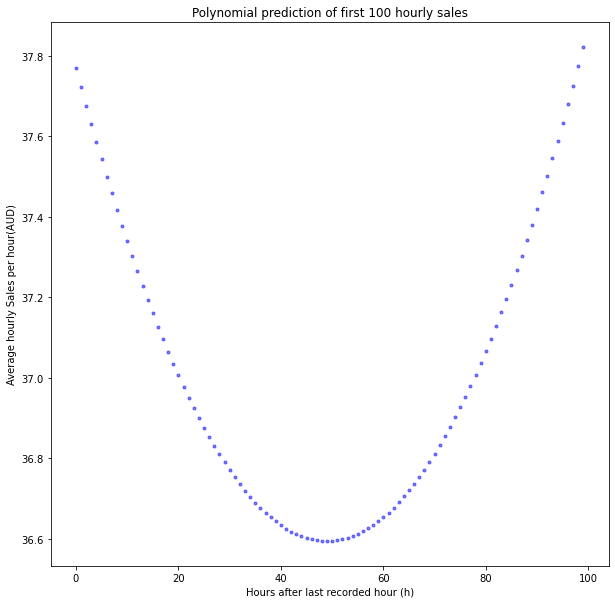

In [197]:
'''
Predictor x = 100 days later after last recorded hour.
'''
hour_th=0
df = pd.DataFrame(columns=('A', 'B'))
for i in range(hour_th,hour_th+100):
    df.loc[i] = [i, i**2]    
betas= np.array([beta[0], beta[1], beta[2]])

new_data = np.hstack((np.ones((df.shape[0],1)), df))
df = np.dot(new_data, betas.T)
df = pd.DataFrame(df, columns = ['Sales (AUD)'])

plt.figure(figsize=(10,10))

plt.plot(df, '.', color = 'blue', alpha = 0.5, linewidth = 0.05)

plt.xlabel('Hours after last recorded hour (h)')
plt.ylabel('Average hourly Sales per hour(AUD)')
plt.title('Polynomial prediction of first 100 hourly sales')

plt.show()

In [198]:
'''
Predictor x = 0~100th hour.
'''
hour_th=0
df = pd.DataFrame(columns=['A', 'B'])
for i in range(hour_th,hour_th+100):
    df.loc[i] = [i, i**2]    
betas= np.array([beta[0], beta[1], beta[2]])

new_data = np.hstack((np.ones((df.shape[0],1)), df))
df = np.dot(new_data, betas.T)
pred_y_1st_100h_beta2 = pd.DataFrame(df, columns = ['Sales (AUD)'])

print(pred_y_1st_100h_beta2)

   Sales (AUD)
0      37.7699
1      37.7224
2      37.6759
3      37.6304
4      37.5858
..         ...
95     37.6332
96     37.6789
97     37.7254
98      37.773
99     37.8216

[100 rows x 1 columns]


In [199]:
true_y = Average_hourly_sales_per_day['Sales (AUD)'].iloc[:100]
print('prediction on 100h (2nd degree) mse: {:.8f}'.format(mse(pred_y_1st_100h_beta2,true_y)))
print('RMSE: {:.4f}'.format(np.sqrt(mse(pred_y_1st_100h_beta2,true_y))))


prediction on 100h (2nd degree) mse: 519.92578075
RMSE: 22.8019


In [200]:
'''
Predictor x = 300 hours later after last recorded hour. 924th
'''
hour_th=924
df = pd.DataFrame(columns=['A','B'])
for i in range(hour_th,hour_th+300):
    df.loc[i] = [i, i**2]    
betas= np.array([beta[0], beta[1], beta[2]])

new_data = np.hstack((np.ones((df.shape[0],1)), df))
df = np.dot(new_data, betas.T)
df = pd.DataFrame(df, columns = ['Sales (AUD)'])

print(df)

    Sales (AUD)
0       411.843
1       412.701
2        413.56
3        414.42
4       415.281
..          ...
295     707.508
296     708.655
297     709.803
298     710.953
299     712.103

[300 rows x 1 columns]


In [201]:
'''
Predictor x = 710th hour = 2019-11-17/1 hour
'''
hour_th=710
data = np.array([[hour_th, hour_th**2]])
betas= np.array([beta[0], beta[1], beta[2]])

new_data = np.hstack((np.ones((data.shape[0],1)), data))
print('2019-11-17/1 hour: ${:.2f}'.format(np.dot(new_data, betas.T)[0]))

2019-11-17/1 hour: $250.74


In [202]:
'''
exam the model on test data
'''
row = X_test.shape[0]
data = X_test
betas= np.array([beta[0], beta[1], beta[2]])
new_data = np.hstack((np.ones((row,1)), data))

# print(new_data @ betas.T)
pred_y_beta2_on_Xtest = new_data @ betas.T
print('prediction on x_test (2nd degree)  mse: {:.8f}'.format(mse(pred_y_beta2_on_Xtest,y_test)))


'''
exam the model on test data
'''
roww = X_train.shape[0]
dataa = X_train
betas= np.array([beta[0], beta[1], beta[2]])
# print(dataa @ betas.T)

predd_y_beta2_on_Xtrain = dataa @ betas.T
print('prediction on x_train (2nd degree) train mse: {:.8f}'.format(mse(predd_y_beta2_on_Xtrain,y_train)))

prediction on x_test (2nd degree)  mse: 1689.64171884
prediction on x_train (2nd degree) train mse: 1515.75532728


### Prediction on 3 degree of polynomial

beta 0: 82.32022772
beta 1: -0.61229447
beta 2: 0.00201469
beta 3: -0.00000110


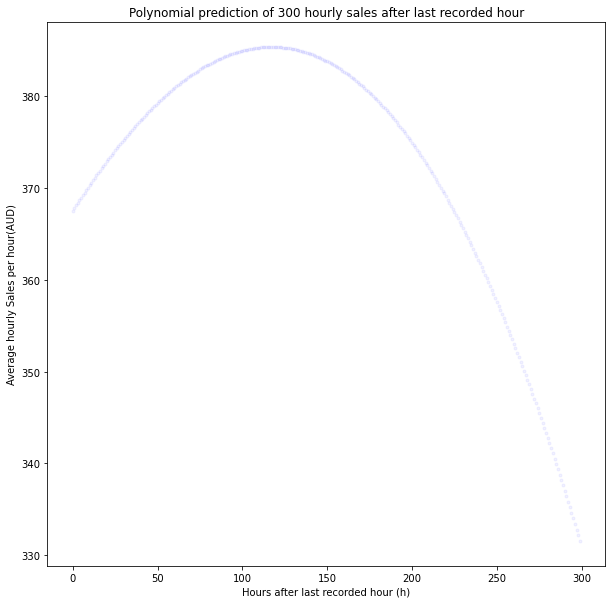

In [203]:
X = Average_hourly_sales_per_day[['days_after_open_index','days_after_open_index^2','days_after_open_index^3']]
y = Average_hourly_sales_per_day['Sales (AUD)'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.4, random_state = 1)

ones = np.ones((X_train.shape[0], 1))
X_train = np.hstack((ones, X_train))

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

for i in range(4):
    print('beta {}: {:.8f}'.format(i, beta[i]))    
'''
Predictor x = 300 hours later after last recorded hour.
'''
hour_th=924
df = pd.DataFrame(columns=('A', 'B', 'C'))
for i in range(hour_th,hour_th+300):
    df.loc[i] = [i, i**2,i**3]    
betas= np.array([beta[0], beta[1], beta[2], beta[3]])

new_data = np.hstack((np.ones((df.shape[0],1)), df))
df = np.dot(new_data, betas.T)
df = pd.DataFrame(df, columns = ['Sales (AUD)'])

plt.figure(figsize=(10,10))

plt.plot(df, '.', color = 'blue', alpha = 0.05, linewidth = 0.05)

plt.xlabel('Hours after last recorded hour (h)')
plt.ylabel('Average hourly Sales per hour(AUD)')
plt.title('Polynomial prediction of 300 hourly sales after last recorded hour')

plt.show()

In [204]:
'''
Predictor x = 0~100th hour, in order to compute mse.
'''
hour_th=0
df = pd.DataFrame(columns=['A','B','C'])
for i in range(hour_th,hour_th+100):
    df.loc[i] = [i, i**2, i**3]    
betas= np.array([beta[0], beta[1], beta[2], beta[3]])

new_data = np.hstack((np.ones((df.shape[0],1)), df))
df = np.dot(new_data, betas.T)
pred_y_1st_100h_beta3 = pd.DataFrame(df, columns = ['Sales (AUD)'])

print(pred_y_1st_100h_beta3)

   Sales (AUD)
0      82.3202
1      81.7099
2      81.1037
3      80.5014
4      79.9032
..         ...
95     41.3903
96     41.1326
97     40.8784
98     40.6276
99     40.3801

[100 rows x 1 columns]


In [205]:
true_y = Average_hourly_sales_per_day['Sales (AUD)'].iloc[:100]
print('prediction on 100h (3rd degree) mse: {:.8f}'.format(mse(pred_y_1st_100h_beta3,true_y)))
print('prediction on 100h (3rd degree) r2: {:.8f}'.format(r2_score(true_y, pred_y_1st_100h_beta3)))
print('RMSE: {:.4f}'.format(np.sqrt(mse(pred_y_1st_100h_beta3,true_y))))

prediction on 100h (3rd degree) mse: 718.38236150
prediction on 100h (3rd degree) r2: -0.55786452
RMSE: 26.8027


In [206]:
'''
exam the model on test data
'''
row = X_test.shape[0]
data = X_test
betas= np.array([beta[0], beta[1], beta[2], beta[3]])
new_data = np.hstack((np.ones((row,1)), data))

print(new_data @ betas.T)
pred_y_beta3_on_Xtrain = new_data @ betas.T

# print(mse(pred_compare, compare))

[327.46045759 264.19714369 130.76193097  82.79276663  31.7149151
  34.9525402  359.31855315 316.8088705   66.79778075 315.80959003
 357.94026017  78.36186317 205.95352326  47.59645683  32.73891963
 143.2839663  338.3100373  365.13723009  62.8372687   38.96592525
 164.48462373 340.88652218  33.06445283  78.13250859 147.92645274
  71.94526306 252.93141918  31.76342938  50.36805921  31.23146472
 334.78818357 225.01962396 134.70460842 356.53188251 277.53518151
 319.28515631  31.83155242 180.19521012  39.65790889 275.8166129
  48.73811474  63.3106855   37.03793715  79.90321445 223.79270555
 300.25840922 131.32265427 329.32683374 108.06646503 229.91951177
  36.68974216 194.88061396 139.83177741  63.73638377  80.50144682
 271.20154251  41.39027541  65.63660778 366.93284092 363.26869329
 353.99610281 276.39022122  56.25151514  42.45488457  36.02248186
 345.866405   353.25522696  60.07040147 189.97184768  74.13996217
 338.74336444  36.31190896 232.9745415   41.26585156  66.02192545
  98.9236623

In [207]:
print('prediction on X_test (2nd degree) mse: {:.8f}'.format(mse(predd_y_beta2_on_Xtrain,y_train)))
print('prediction on X_test (3nd degree) mse: {:.8f}'.format(mse(pred_y_beta3_on_Xtrain,y_test)))
print('RMSE(2nd degree): {:.4f}'.format(np.sqrt(mse(predd_y_beta2_on_Xtrain,y_train))))
print('RMSE(3nd degree): {:.4f}'.format(np.sqrt(mse(pred_y_beta3_on_Xtrain,y_test))))

prediction on X_test (2nd degree) mse: 1515.75532728
prediction on X_test (3nd degree) mse: 1305.39894011
RMSE(2nd degree): 38.9327
RMSE(3nd degree): 36.1303


## Adjusted Polynomial: Days_after_open vs Daily sales:

In [208]:
Daily_sales = combine.groupby(['days_after_open'])['Sales (AUD)'].sum()
Daily_sales

days_after_open
0       280.1
1       349.9
2       350.9
3       315.1
4       187.6
        ...  
149    2115.1
150    2099.7
151    1755.1
152    1852.4
153    1859.7
Name: Sales (AUD), Length: 154, dtype: float64

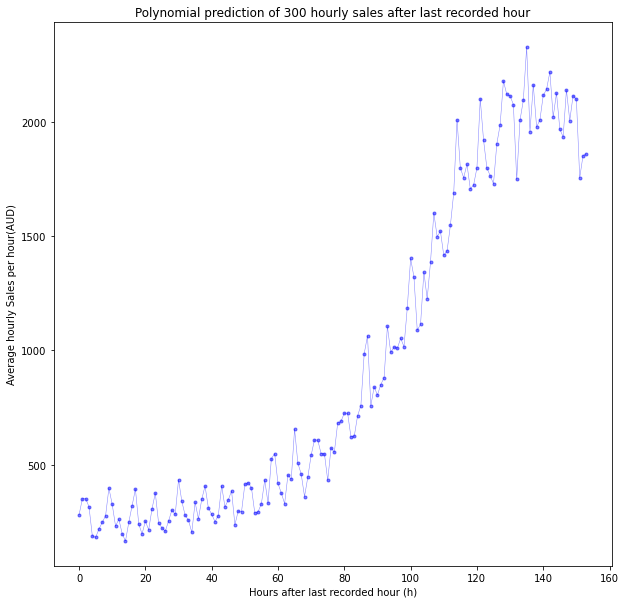

In [209]:
plt.figure(figsize=(10,10))

plt.plot(Daily_sales, '.-', color = 'blue', alpha = 0.5, linewidth = 0.5)

plt.xlabel('Hours after last recorded hour (h)')
plt.ylabel('Average hourly Sales per hour(AUD)')
plt.title('Polynomial prediction of 300 hourly sales after last recorded hour')

plt.show()

beta 0: 497.47256453
beta 1: -23.64227829
beta 2: 0.46571074
beta 3: -0.00156129


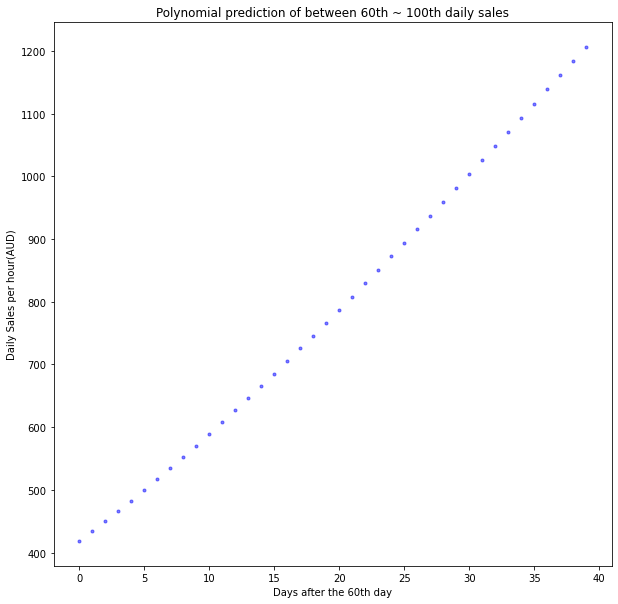

In [210]:
Daily_sales = combine.groupby(['days_after_open'])['Sales (AUD)'].sum().reset_index()
Daily_sales['days_after_open_index'] = range(1, len(Daily_sales) + 1)
#https://stackoverflow.com/questions/12168648/pandas-python-how-to-add-column-to-dataframe-for-index

Daily_sales['days_after_open_index^2'] = Daily_sales['days_after_open_index']**2
Daily_sales['days_after_open_index^3'] = Daily_sales['days_after_open_index']**3

X = Daily_sales[['days_after_open_index','days_after_open_index^2','days_after_open_index^3']]
y = Daily_sales['Sales (AUD)'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)

ones = np.ones((X_train.shape[0], 1))
X_train = np.hstack((ones, X_train))

beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

for i in range(4):
    print('beta {}: {:.8f}'.format(i, beta[i]))    
'''
Predictor x = between 60th ~ 100th days.
'''
hour_th=60
df = pd.DataFrame(columns=('A', 'B', 'C'))
for i in range(hour_th,hour_th+40):
    df.loc[i] = [i, i**2,i**3]    
betas= np.array([beta[0], beta[1], beta[2], beta[3]])

new_data = np.hstack((np.ones((df.shape[0],1)), df))
df = np.dot(new_data, betas.T)
prediction_daily_beta3 = pd.DataFrame(df, columns = ['Sales (AUD)'])

plt.figure(figsize=(10,10))

plt.plot(df, '.', color = 'blue', alpha = 0.5)

plt.xlabel('Days after the 60th day')
plt.ylabel('Daily Sales per hour(AUD)')
plt.title('Polynomial prediction of between 60th ~ 100th daily sales')

plt.show()

In [211]:
true_y = Daily_sales['Sales (AUD)'].iloc[60:100]

print("mse of prediction: {:.4f}".format(mse(prediction_daily_beta3,true_y)))
print("r2 of prediction: {:.4f}".format(r2_score(true_y,prediction_daily_beta3)))
print('RMSE: {:.4f}'.format(np.sqrt(mse(prediction_daily_beta3,true_y))))

mse of prediction: 16502.9852
r2 of prediction: 0.6937
RMSE: 128.4639


## Multiple Linear Regression on Hourly sales:

In [212]:
from sklearn.linear_model import LinearRegression


cl_regression.rename(columns={"index": "hours_open_till_enddate"},inplace = True)
cl_fine =  cl_regression.iloc[:,[0,3,4,5,6,7,8,9,10,11]]

X = cl_fine.iloc[:,:9].to_numpy().reshape(-1,9)
y = cl_regression['Sales (AUD)'].to_numpy()
linear_reg = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 1)


linear_reg.fit(X_train, y_train)

pred_y = linear_reg.predict(X_test)
r2=metrics.r2_score(y_test, pred_y)
print('r2 of X_train: {}'. format(r2))
print("beta 0: {:.2f}".format(linear_reg.intercept_))

for i in range(9):
    print("beta {}: {:.2f}".format(i+1, linear_reg.coef_[i]))

r2 of X_train: 0.8659783830312306
beta 0: -24.96
beta 1: 0.41
beta 2: 0.00
beta 3: -0.62
beta 4: -12.53
beta 5: -10.54
beta 6: 12.15
beta 7: 2.04
beta 8: 26.40
beta 9: -39.52


In [213]:
for col in cl_fine.columns:
    print(col)

hours_open_till_enddate
dist_to_cafe
day_of_week_Mon
day_of_week_Sat
day_of_week_Sun
day_of_week_Thu
day_of_week_Tue
day_of_week_Wed
raining_Yes
Sales (AUD)


In [214]:
'''
Hourly sales prediction on:
3rd hour, 240 distance to cafe, Monday
'''
# new_X = np.array([[919, 240, 1, 0,0,0,0,0,844561,776151559]])
new_X = np.array([[2, 77, 1, 0,0,0,0,0,1]])
pred_y = linear_reg.predict(new_X)
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X) 
# https://datatofish.com/multiple-linear-regression-python/
print_model = model.summary()

In [215]:
print(print_model)
print(pred_y)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     638.1
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        17:31:08   Log-Likelihood:                -4817.5
No. Observations:                 924   AIC:                             9655.
Df Residuals:                     914   BIC:                             9703.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.5889      8.988     -1.846      0.0

In [216]:
# cl_regression
check_data = cl_regression.loc[(cl_regression['dist_to_cafe'] == 77 ) & ( cl_regression['day_of_week_Mon'] == 1) & (cl_regression['hours_open_till_enddate'] == 2)]
check_data

,hours_open_till_enddate,Daily_transaction,hours_after_open,dist_to_cafe,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,day_of_week_Wed,raining_Yes,Sales (AUD)
2,2,2019-07-22/2,2.0,77.0,1,0,0,0,0,0,1,37.3
